### **Load Libraries**

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from google.colab import drive
import os, shutil
import random
import numpy as np
import pandas as pd
import cv2
import skimage
import matplotlib.pyplot as plt
import skimage.segmentation
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
import tensorflow_hub as hub
import time

# Data augmentation and model preparation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2, NASNetMobile
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.nasnet import preprocess_input as nasnet_preprocess
from tensorflow.keras.layers import (AveragePooling2D, Dropout, Flatten, Dense, Input,
                                    GlobalAveragePooling2D, Conv2D, DepthwiseConv2D,
                                    BatchNormalization, Activation, Add, Reshape, multiply,
                                    Concatenate, MaxPooling2D)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

### **Define Paths & Load Data**

In [ ]:
# NIH Dataset paths
BASE_PATH = "/content/drive/MyDrive/NIH_processed"
TRAIN_PATH = "/content/drive/MyDrive/NIH_processed/train"
TEST_PATH = "/content/drive/MyDrive/NIH_processed/test"

labels = ['normal', 'pneumonia']
img_size = 224

def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                data.append([img_path, label])
            except Exception as e:
                print(e)
    return pd.DataFrame(data, columns=['filepath', 'label'])

# Load data
train = get_data(TRAIN_PATH)
test = get_data(TEST_PATH)

print(train.head(5))
print(f"\nThe shape of The Train data is: {train.shape}")
print(f"The shape of The Test data is: {test.shape}")

                                            filepath   label
0  /content/drive/MyDrive/NIH_processed/train/nor...  normal
1  /content/drive/MyDrive/NIH_processed/train/nor...  normal
2  /content/drive/MyDrive/NIH_processed/train/nor...  normal
3  /content/drive/MyDrive/NIH_processed/train/nor...  normal
4  /content/drive/MyDrive/NIH_processed/train/nor...  normal

The shape of The Train data is: (5320, 2)
The shape of The Test data is: (1784, 2)


In [ ]:
# Check class imbalance
def check_class_imbalance(directory):
    """Check class distribution in the dataset"""
    print(f"Checking class distribution in: {directory}")
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            print(f"  {class_name}: {count} images")
    print()

print("NIH Dataset Class Distribution:")
check_class_imbalance(TRAIN_PATH)
check_class_imbalance(TEST_PATH)

NIH Dataset Class Distribution:
Checking class distribution in: /content/drive/MyDrive/NIH_processed/train
  normal: 4069 images
  pneumonia: 1251 images

Checking class distribution in: /content/drive/MyDrive/NIH_processed/test
  normal: 1272 images
  pneumonia: 512 images



In [ ]:
# Create datasets
IMAGE_SIZE = (224, 224)

print('\nTraining Images:')
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

print('\nValidation Images:')
validation_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

print('\nTesting Images:')
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_PATH,
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

# Get class names
train_labels = train_ds.class_names
test_labels = test_ds.class_names
validation_labels = validation_ds.class_names

class_labels =['pneumonia', 'normal']
label_encoder = LabelEncoder()
label_encoder.fit(class_labels)

# Normalize pixel values
train_ds = train_ds.map(lambda x, y: (x / 255.0, y))
validation_ds = validation_ds.map(lambda x, y: (x / 255.0, y))
test_ds = test_ds.map(lambda x, y: (x / 255.0, y))


Training Images:
Found 5320 files belonging to 2 classes.
Using 4256 files for training.

Validation Images:
Found 5320 files belonging to 2 classes.
Using 1064 files for validation.

Testing Images:
Found 1784 files belonging to 2 classes.


In [ ]:
# Count files
def retrieveNumberOfFiles(path):
    return len([f for f in os.listdir(os.path.join(path, "normal")) if f.endswith(('png', 'jpg', 'jpeg'))] +
               [f for f in os.listdir(os.path.join(path, "pneumonia")) if f.endswith(('png', 'jpg', 'jpeg'))])

totalTrain = retrieveNumberOfFiles(TRAIN_PATH)
totalTest = retrieveNumberOfFiles(TEST_PATH)

# Get class weights
allTrainFiles = [os.path.join(TRAIN_PATH, "normal", f) for f in os.listdir(os.path.join(TRAIN_PATH, "normal"))] + \
                [os.path.join(TRAIN_PATH, "pneumonia", f) for f in os.listdir(os.path.join(TRAIN_PATH, "pneumonia"))]

trainLabels = [0 if "normal" in p else 1 for p in allTrainFiles]
trainLabels = to_categorical(trainLabels)
classTotals = trainLabels.sum(axis=0)
classWeight = {i: classTotals.max() / classTotals[i] for i in range(len(classTotals))}

# Data generators
BATCH_SIZE = 32
INIT_LR = 1e-4
EPOCHS = 25

trainAug = ImageDataGenerator(
    preprocessing_function=mobilenet_preprocess,
    rotation_range=20,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode="nearest")

valAug = ImageDataGenerator(preprocessing_function=mobilenet_preprocess)

trainGen = trainAug.flow_from_directory(
    TRAIN_PATH,
    class_mode="categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle=True,
    batch_size=BATCH_SIZE)

validationGen = valAug.flow_from_directory(
    TRAIN_PATH,
    class_mode="categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle=False,
    batch_size=BATCH_SIZE)

testGen = valAug.flow_from_directory(
    TEST_PATH,
    class_mode="categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle=False,
    batch_size=BATCH_SIZE)

Found 5320 images belonging to 2 classes.
Found 5320 images belonging to 2 classes.
Found 1784 images belonging to 2 classes.


#### **Build the Custom Model (PneumoLiteCovNet25)**

In [ ]:
# Squeeze and Excitation block
def squeeze_excite_block(input_tensor, ratio=8):
    init = input_tensor
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = multiply([init, se])
    return x

# Inverted Residual Block with SE
def inverted_residual_block(inputs, filters, kernel_size=3, strides=1, expansion_factor=6, se_ratio=8, use_residual=True):
    channel_axis = -1
    in_channels = inputs.shape[channel_axis]

    # Expansion phase
    x = Conv2D(in_channels * expansion_factor, kernel_size=1, padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Depthwise Convolution
    x = DepthwiseConv2D(kernel_size=kernel_size, strides=strides, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Squeeze and Excitation
    x = squeeze_excite_block(x, ratio=se_ratio)

    # Pointwise Convolution
    x = Conv2D(filters, kernel_size=1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)

    # Residual connection if possible
    if use_residual and strides == 1 and in_channels == filters:
        return Add()([inputs, x])
    return x

# Multi-scale feature extraction block
def multi_scale_block(inputs, filters):
    # Branch 1: 1x1 convolution
    branch1 = Conv2D(filters, kernel_size=1, padding='same')(inputs)
    branch1 = BatchNormalization()(branch1)
    branch1 = Activation('relu')(branch1)

    # Branch 2: 3x3 convolution
    branch2 = Conv2D(filters, kernel_size=3, padding='same')(inputs)
    branch2 = BatchNormalization()(branch2)
    branch2 = Activation('relu')(branch2)

    # Branch 3: 5x5 convolution (implemented as two 3x3 convs)
    branch3 = Conv2D(filters, kernel_size=3, padding='same')(inputs)
    branch3 = BatchNormalization()(branch3)
    branch3 = Activation('relu')(branch3)
    branch3 = Conv2D(filters, kernel_size=3, padding='same')(branch3)
    branch3 = BatchNormalization()(branch3)
    branch3 = Activation('relu')(branch3)

    # Concatenate branches
    x = Concatenate(axis=-1)([branch1, branch2, branch3])

    # 1x1 convolution to reduce channels
    x = Conv2D(filters, kernel_size=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

# Build PneumoLightCovNet-25 model
def build_pneumolightcovnet25(input_shape=(224, 224, 3), classes=2):
    inputs = Input(shape=input_shape)

    # Initial convolution
    x = Conv2D(32, kernel_size=3, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # First block
    x = inverted_residual_block(x, 16, strides=1, expansion_factor=1, use_residual=False)

    # Second block
    x = inverted_residual_block(x, 24, strides=2, expansion_factor=6)
    x = inverted_residual_block(x, 24, strides=1, expansion_factor=6)

    # Third block with multi-scale features
    x = inverted_residual_block(x, 32, strides=2, expansion_factor=6)
    x = inverted_residual_block(x, 32, strides=1, expansion_factor=6)
    x = multi_scale_block(x, 32)

    # Fourth block
    x = inverted_residual_block(x, 64, strides=2, expansion_factor=6)
    x = inverted_residual_block(x, 64, strides=1, expansion_factor=6)
    x = inverted_residual_block(x, 64, strides=1, expansion_factor=6)
    x = inverted_residual_block(x, 64, strides=1, expansion_factor=6)

    # Fifth block with multi-scale features
    x = inverted_residual_block(x, 96, strides=1, expansion_factor=6)
    x = inverted_residual_block(x, 96, strides=1, expansion_factor=6)
    x = multi_scale_block(x, 96)

    # Sixth block
    x = inverted_residual_block(x, 160, strides=2, expansion_factor=6)
    x = inverted_residual_block(x, 160, strides=1, expansion_factor=6)
    x = inverted_residual_block(x, 160, strides=1, expansion_factor=6)

    # Final convolution
    x = Conv2D(320, kernel_size=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Global pooling and classification
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=x, name='PneumoLightCovNet-25')
    return model

# Create model
CLASSES = ["normal", "pneumonia"]
model = build_pneumolightcovnet25(input_shape=(224, 224, 3), classes=len(CLASSES))

In [ ]:
model.summary()

Model: "PneumoLightCovNet-25"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 112, 112,  │      1,024 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d    │ (None, 112, 112,  │        288 │ activation_1[0][… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        128 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ activation_2[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 32)  │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 1, 4)   │        128 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1, 1, 32)  │        128 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 112, 112,  │          0 │ activation_2[0][… │
│                     │ 32)               │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │        512 │ multiply[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │         64 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │      1,536 │ batch_normalizat

 Total params: 2,491,234 (9.50 MB)

 Trainable params: 2,465,506 (9.41 MB)

 Non-trainable params: 25,728 (100.50 KB)

#### **Compile & Train Model**

In [ ]:
# Compile model
print("Compiling model")
opt = Adam(learning_rate=INIT_LR)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# Add callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1) # Increased patience
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1) # Increased patience

# Callbacks
os.makedirs("/content/drive/MyDrive/NIH_processed/New_NIH_Models/PneumoLiteCovNet-25", exist_ok=True)
MCName = os.path.sep.join(["/content/drive/MyDrive/NIH_processed/New_NIH_Models/PneumoLiteCovNet-25", "pneumolightcovnet25_weights-{epoch:03d}-{val_loss:.4f}.keras"])
checkpoint = ModelCheckpoint(
    MCName,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    verbose=1,
    save_weights_only=False
)
callbacks = [checkpoint, reduce_lr, early_stopping]

# Train model
print("Model Fitting")
start_time = time.time()

# Adjust class weights - increasing weight for pneumonia
classWeight = {0: 1.0, 1: 5.0}


history = model.fit(
    x=trainGen,
    steps_per_epoch=totalTrain // BATCH_SIZE,
    validation_data=validationGen,
    validation_steps=validationGen.samples // BATCH_SIZE,
    class_weight=classWeight,
    callbacks=callbacks,
    epochs=EPOCHS)

training_time = (time.time() - start_time) / 60
print(f"\nTraining completed in {training_time:.2f} minutes")

Compiling model
Model Fitting
Epoch 1/25
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3882 - loss: 1.3104
Epoch 1: val_loss improved from inf to 0.87089, saving model to /content/drive/MyDrive/NIH_processed/New_NIH_Models/PneumoLiteCovNet-25/pneumolightcovnet25_weights-001-0.8709.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 575s 3s/step - accuracy: 0.3881 - loss: 1.3103 - val_accuracy: 0.2340 - val_loss: 0.8709 - learning_rate: 1.0000e-04
Epoch 2/25
  1/166 ━━━━━━━━━━━━━━━━━━━━ 5:49 2s/step - accuracy: 0.4375 - loss: 1.1348

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss did not improve from 0.87089
166/166 ━━━━━━━━━━━━━━━━━━━━ 134s 797ms/step - accuracy: 0.4375 - loss: 1.1348 - val_accuracy: 0.2340 - val_loss: 0.8716 - learning_rate: 1.0000e-04
Epoch 3/25
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4413 - loss: 1.2537
Epoch 3: val_loss improved from 0.87089 to 0.85555, saving model to /content/drive/MyDrive/NIH_processed/New_NIH_Models/PneumoLiteCovNet-25/pneumolightcovnet25_weights-003-0.8555.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 532s 3s/step - accuracy: 0.4411 - loss: 1.2538 - val_accuracy: 0.2340 - val_loss: 0.8555 - learning_rate: 1.0000e-04
Epoch 4/25
  1/166 ━━━━━━━━━━━━━━━━━━━━ 5:52 2s/step - accuracy: 0.5938 - loss: 1.2006
Epoch 4: val_loss improved from 0.85555 to 0.85325, saving model to /content/drive/MyDrive/NIH_processed/New_NIH_Models/PneumoLiteCovNet-25/pneumolightcovnet25_weights-004-0.8533.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 136s 811ms/step - accuracy: 0.5938 - loss: 1.2006 - val_accuracy: 0.2340 - val_loss: 0

#### **Plot Training Curves**

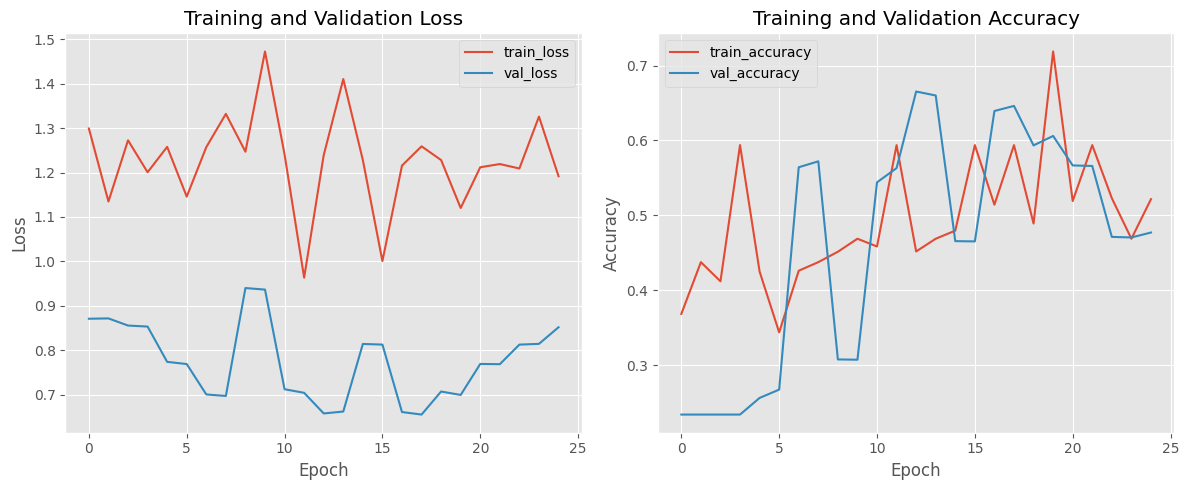

In [ ]:
# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### **Evaluation**


Evaluating model...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


56/56 ━━━━━━━━━━━━━━━━━━━━ 960s 17s/step - accuracy: 0.6664 - loss: 0.6600
Test Accuracy: 65.86%
Test Loss: 0.6535
56/56 ━━━━━━━━━━━━━━━━━━━━ 48s 828ms/step

Classification Report:
              precision    recall  f1-score   support

      normal     0.8191    0.6690    0.7365      1272
   pneumonia     0.4349    0.6328    0.5155       512

    accuracy                         0.6586      1784
   macro avg     0.6270    0.6509    0.6260      1784
weighted avg     0.7088    0.6586    0.6731      1784


Confusion Matrix:
[[851 421]
 [188 324]]
Accuracy: 0.6586
Sensitivity: 0.6328
Specificity: 0.6690


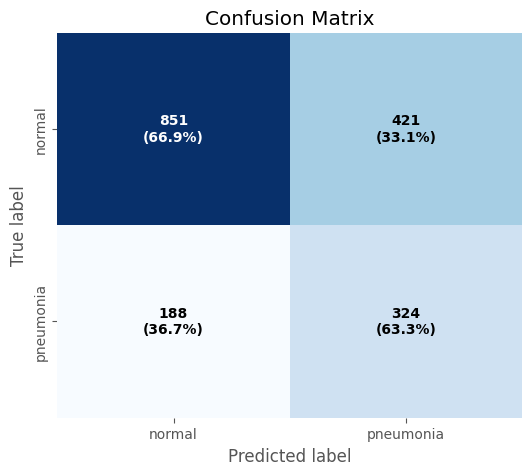


AUROC Score: 0.6896


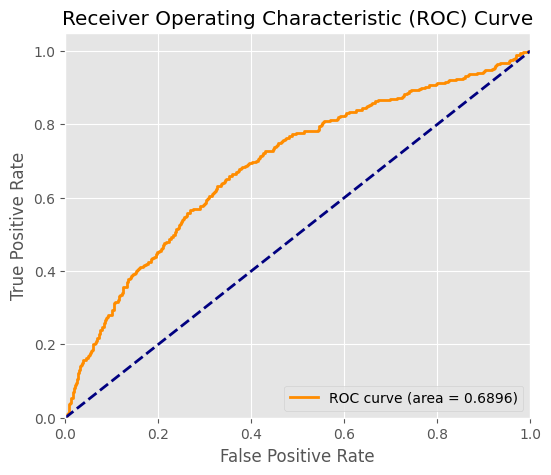

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Evaluate model
print("\nEvaluating model...")
test_results = model.evaluate(testGen, batch_size=BATCH_SIZE)
print("Test Accuracy: {:.2f}%".format(test_results[1] * 100))
print("Test Loss: {:.4f}".format(test_results[0]))

# Predictions and classification report
predIdxs = model.predict(testGen)
predTest = np.argmax(predIdxs, axis=1)

print("\nClassification Report:")
print(classification_report(testGen.classes, predTest, target_names=testGen.class_indices.keys(), digits=4))

# Confusion matrix
cm = confusion_matrix(testGen.classes, predTest)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

print("\nConfusion Matrix:")
print(cm)
print("Accuracy: {:.4f}".format(acc))
print("Sensitivity: {:.4f}".format(sensitivity))
print("Specificity: {:.4f}".format(specificity))

# Plot confusion matrix with class-wise percentages
plt.figure(figsize=(6, 5))
ax = sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
                xticklabels=testGen.class_indices.keys(),
                yticklabels=testGen.class_indices.keys(),
                cbar=False)

# Add bold annotations (true negative in white)
for i in range(cm.shape[0]):
    row_sum = cm[i, :].sum()
    for j in range(cm.shape[1]):
        percentage = (cm[i, j] / row_sum) * 100 if row_sum > 0 else 0
        color = "white" if (i == 0 and j == 0) else "black"
        ax.text(j + 0.5, i + 0.5, f"{cm[i, j]}\n({percentage:.1f}%)",
                ha='center', va='center', color=color, fontweight='bold')

plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Calculate and plot AUROC
pred_probs = predIdxs[:, 1]
fpr, tpr, thresholds = roc_curve(testGen.classes, pred_probs)
roc_auc = auc(fpr, tpr)

print(f"\nAUROC Score: {roc_auc:.4f}")

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

#### **Evaluate from Best saved model**

In [ ]:
# Load the best saved model
best_model_path = "/content/drive/MyDrive/NIH_processed/New_NIH_Models/PneumoLiteCovNet-25/pneumolightcovnet25_weights-018-0.6552.keras"
model = tf.keras.models.load_model(best_model_path)

print(f"Loaded model from: {best_model_path}")

Loaded model from: /content/drive/MyDrive/NIH_processed/New_NIH_Models/PneumoLiteCovNet-25/pneumolightcovnet25_weights-018-0.6552.keras



Evaluating model...
56/56 ━━━━━━━━━━━━━━━━━━━━ 45s 801ms/step - accuracy: 0.6664 - loss: 0.6600
Test Accuracy: 65.86%
Test Loss: 0.6535
56/56 ━━━━━━━━━━━━━━━━━━━━ 45s 800ms/step

Classification Report:
              precision    recall  f1-score   support

      normal     0.8191    0.6690    0.7365      1272
   pneumonia     0.4349    0.6328    0.5155       512

    accuracy                         0.6586      1784
   macro avg     0.6270    0.6509    0.6260      1784
weighted avg     0.7088    0.6586    0.6731      1784


Confusion Matrix:
[[851 421]
 [188 324]]
Accuracy: 0.6586
Sensitivity: 0.6328
Specificity: 0.6690


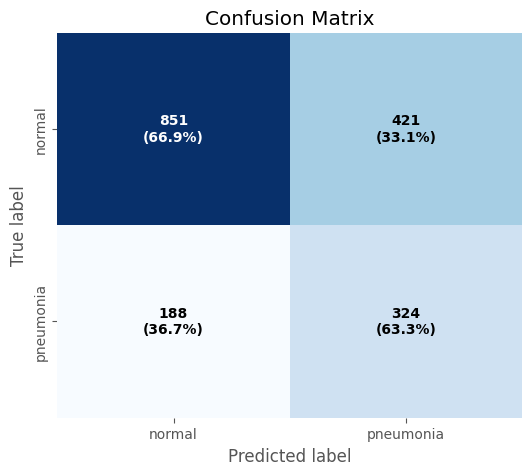


AUROC Score: 0.6896


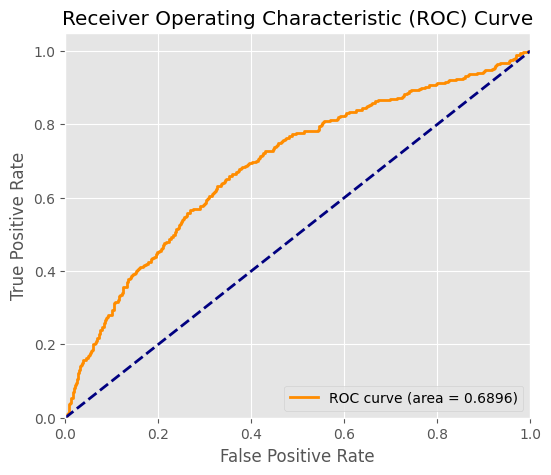

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Evaluate model
print("\nEvaluating model...")
test_results = model.evaluate(testGen, batch_size=BATCH_SIZE)
print("Test Accuracy: {:.2f}%".format(test_results[1] * 100))
print("Test Loss: {:.4f}".format(test_results[0]))

# Predictions and classification report
predIdxs = model.predict(testGen)
predTest = np.argmax(predIdxs, axis=1)

print("\nClassification Report:")
print(classification_report(testGen.classes, predTest, target_names=testGen.class_indices.keys(), digits=4))

# Confusion matrix
cm = confusion_matrix(testGen.classes, predTest)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

print("\nConfusion Matrix:")
print(cm)
print("Accuracy: {:.4f}".format(acc))
print("Sensitivity: {:.4f}".format(sensitivity))
print("Specificity: {:.4f}".format(specificity))

# Plot confusion matrix with class-wise percentages
plt.figure(figsize=(6, 5))
ax = sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
                xticklabels=testGen.class_indices.keys(),
                yticklabels=testGen.class_indices.keys(),
                cbar=False)

# Add bold annotations (true negative in white)
for i in range(cm.shape[0]):
    row_sum = cm[i, :].sum()
    for j in range(cm.shape[1]):
        percentage = (cm[i, j] / row_sum) * 100 if row_sum > 0 else 0
        color = "white" if (i == 0 and j == 0) else "black"
        ax.text(j + 0.5, i + 0.5, f"{cm[i, j]}\n({percentage:.1f}%)",
                ha='center', va='center', color=color, fontweight='bold')

plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Calculate and plot AUROC
pred_probs = predIdxs[:, 1]
fpr, tpr, thresholds = roc_curve(testGen.classes, pred_probs)
roc_auc = auc(fpr, tpr)

print(f"\nAUROC Score: {roc_auc:.4f}")

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

#### **Model Size**

In [ ]:
import os

# Define the path to the loaded model file
best_model_path = "/content/drive/MyDrive/NIH_processed/New_NIH_Models/PneumoLiteCovNet-25/pneumolightcovnet25_weights-018-0.6552.keras"

# Get the size of the loaded model file
model_size_bytes = os.path.getsize(best_model_path)
model_size_mb = model_size_bytes / (1024 * 1024)

print(f"Model size: {model_size_bytes} bytes")
print(f"Model size: {model_size_mb:.2f} MB")

Model size: 30649438 bytes
Model size: 29.23 MB
